In [1]:
from Functions import*


In [2]:
import glob

In [3]:
#function that create a list from lines in a txt file
#allows to know which image is in which set
def create_list_from_txt(filename):
    FILE = filename
 
    with open(FILE, 'r') as f:
        lines = [line.strip('\n') for line in f.readlines()]
 
    list_img = [line for line in lines]
    
    return list_img
   

In [4]:
#function that create the lists of image but already split in test, train and val sets
#we are going to use this function to load data in the right sets
#two times  for COVID and NonCOVID

#set_type is either train,test or val
def create_set_list_splits(covid): 
    folder_path='/tf/Project/Data_split'
    if covid==True:
        set_dir=os.path.join(folder_path+'/COVID')
    else: 
        set_dir=os.path.join(folder_path+'/NonCOVID')
    
    
    list_files=glob.glob(set_dir+'/*.txt')
    list_files.sort()
    #to ensure the order of sets as test , train and val (alphabetic order)
    
    
    test_list=create_list_from_txt(list_files[0])
    train_list=create_list_from_txt(list_files[1])
    val_list=create_list_from_txt(list_files[2])
    
    return test_list, train_list, val_list

In [5]:
#add the name of image to the name of folder
#create the full name of the image to be loaded
def list_dir(set_list,set_dir):
    new_data=[]
    for x in set_list:
        new = os.path.join(set_dir,x)
        new_data.append(new)
    return new_data

In [6]:
#tbl stands for to be loaded
def create_list_to_load(test_list,train_list, val_list, covid):
    img_path='/tf/Project'
    
    if covid==True:
        set_dir=os.path.join(img_path+'/CT_COVID')
    else: 
        set_dir=os.path.join(img_path+'/CT_NonCOVID')
    
    test_list_tbl=list_dir(test_list,set_dir)
    train_list_tbl=list_dir(train_list,set_dir)
    val_list_tbl=list_dir(val_list,set_dir)
    
    return test_list_tbl, train_list_tbl, val_list_tbl

In [7]:
def load_data(data_list,img_w,img_h,img_ch):
    tab = np.zeros((len(data_list),img_w,img_h,img_ch),dtype='float32')
    for i in range(len(data_list)):
        Img = cv2.imread(data_list[i],0)
        Img = cv2.resize(Img,(img_w, img_h))
        Img = Img.reshape(img_w,img_h)/255
        tab[i,:,:,0]=Img
    return tab

In [8]:
def create_list_labels(set_list,covid): 
    list_labels=[]
    for i in range(len(set_list)):
        if covid==True:
            list_labels.append(1)
        else:
            list_labels.append(0)
    return list_labels

In [9]:
def concatenate_lists_and_labels(list1,labels1,list2,labels2):
    return list1+list2, labels1+labels2

In [10]:
def shuffle_lists(list_img, list_labels):
    index_position = list(zip(list_img, list_labels))
    random.shuffle(index_position)
    list_img[:],list_labels[:] = zip(*index_position)
    return list_img,list_labels

In [11]:
def precision(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_pred_f) + K.epsilon())

def recall(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_true_f) + K.epsilon())

In [12]:
#labels is an array
def augmentation(image_set,labels,dictionary_augmentation,batch_size):
    
    image_datagen = ImageDataGenerator(**dictionary_augmentation)

    image_generator = image_datagen.flow(
    image_set,
    y=labels,
    batch_size=batch_size,
    shuffle=False,
    seed=1)

    
    
    return image_generator


In [13]:
test_list_covid, train_list_covid, val_list_covid=create_set_list_splits(covid=True)
test_list_Noncovid, train_list_Noncovid, val_list_Noncovid=create_set_list_splits(covid=False)

In [14]:
test_list_tbl_covid, train_list_tbl_covid,val_list_tbl_covid=create_list_to_load(test_list_covid,train_list_covid, val_list_covid, covid=True)

test_list_tbl_Noncovid, train_list_tbl_Noncovid,val_list_tbl_Noncovid=create_list_to_load(test_list_Noncovid,train_list_Noncovid, val_list_Noncovid, covid=False)

In [15]:
test_covid_labels=create_list_labels(test_list_covid,covid=True)
train_covid_labels=create_list_labels(train_list_covid,covid=True)
val_covid_labels=create_list_labels(val_list_covid,covid=True)

test_Noncovid_labels=create_list_labels(test_list_Noncovid,covid=False)
train_Noncovid_labels=create_list_labels(train_list_Noncovid,covid=False)
val_Noncovid_labels=create_list_labels(val_list_Noncovid,covid=False)

In [16]:
test_list_tbl,test_labels=concatenate_lists_and_labels(test_list_tbl_covid,test_covid_labels,test_list_tbl_Noncovid,test_Noncovid_labels)
train_list_tbl,train_labels=concatenate_lists_and_labels(train_list_tbl_covid,train_covid_labels,train_list_tbl_Noncovid,train_Noncovid_labels)
val_list_tbl,val_labels=concatenate_lists_and_labels(val_list_tbl_covid,val_covid_labels,val_list_tbl_Noncovid,val_Noncovid_labels)

In [17]:
test_list_tbl,test_labels=shuffle_lists(test_list_tbl, test_labels)
train_list_tbl,train_labels=shuffle_lists(train_list_tbl, train_labels)
val_list_tbl,val_labels=shuffle_lists(val_list_tbl, val_labels)



In [18]:
#the article precises the size of the images as (480,480)

img_w,img_h,img_ch=480,480,1

test_set=load_data(test_list_tbl,img_w,img_h,img_ch)
train_set=load_data(train_list_tbl,img_w,img_h,img_ch)
val_set=load_data(val_list_tbl,img_w,img_h,img_ch)

test_labels=np.array(test_labels)
train_labels=np.array(train_labels)
val_labels=np.array(val_labels)


In [19]:
from skimage.io import imshow

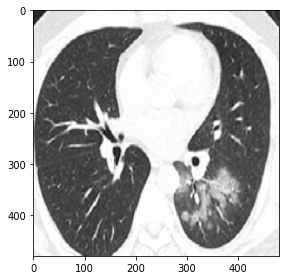

In [20]:
imshow(np.squeeze(test_set[0]))

In [21]:
from tensorflow.keras.layers import Conv2D,AveragePooling2D,add, GlobalAveragePooling2D, ReLU

In [23]:
INPUT_SHAPE=480,480,1
N_CLASSES=1

K.clear_session()
my_model=densenet(INPUT_SHAPE,N_CLASSES,dropout=True,dr=0.2)
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 120, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v2_1 (Batch (None, 120, 120, 64) 256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [24]:
learning_rate=0.00001
optimizer=Adam(learning_rate)
batch_size=16
loss_function = 'binary_crossentropy'
metrics=['binary_accuracy',precision,recall]
n_epochs=100

In [30]:
#data augmentation
dictionary_augmentation = dict(
                     rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,       
                     horizontal_flip=True,
                     brightness_range=[0,2])


In [31]:
 STEP_SIZE_TRAIN=len(train_set)//batch_size

In [32]:
train_generator=augmentation(train_set,train_labels,dictionary_augmentation,batch_size)

In [33]:
my_model.compile(loss=loss_function,optimizer = optimizer,metrics=['binary_accuracy'])

In [34]:
model_hist=my_model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=(val_set,val_labels)
                        ,epochs=n_epochs,verbose=1)

Epoch 1/100
26/26 [==============================] - 22s 845ms/step - loss: 0.6912 - binary_accuracy: 0.5452 - val_loss: 0.6930 - val_binary_accuracy: 0.5085
Epoch 2/100
26/26 [==============================] - 6s 239ms/step - loss: 0.6812 - binary_accuracy: 0.5575 - val_loss: 0.6938 - val_binary_accuracy: 0.4915
Epoch 3/100
26/26 [==============================] - 6s 237ms/step - loss: 0.6712 - binary_accuracy: 0.5672 - val_loss: 0.6945 - val_binary_accuracy: 0.4915
Epoch 4/100
26/26 [==============================] - 6s 238ms/step - loss: 0.6624 - binary_accuracy: 0.5770 - val_loss: 0.7097 - val_binary_accuracy: 0.4915
Epoch 5/100
26/26 [==============================] - 6s 236ms/step - loss: 0.6324 - binary_accuracy: 0.6601 - val_loss: 0.7172 - val_binary_accuracy: 0.4915
Epoch 6/100
26/26 [==============================] - 6s 237ms/step - loss: 0.6361 - binary_accuracy: 0.6418 - val_loss: 0.6964 - val_binary_accuracy: 0.4915
Epoch 7/100
26/26 [==============================] - 6s 2

Epoch 53/100
26/26 [==============================] - 6s 241ms/step - loss: 0.5748 - binary_accuracy: 0.6895 - val_loss: 0.7329 - val_binary_accuracy: 0.4915
Epoch 54/100
26/26 [==============================] - 6s 244ms/step - loss: 0.5826 - binary_accuracy: 0.6895 - val_loss: 0.7462 - val_binary_accuracy: 0.4915
Epoch 55/100
26/26 [==============================] - 6s 245ms/step - loss: 0.5721 - binary_accuracy: 0.6968 - val_loss: 0.7419 - val_binary_accuracy: 0.4915
Epoch 56/100
26/26 [==============================] - 6s 246ms/step - loss: 0.5518 - binary_accuracy: 0.6968 - val_loss: 0.8541 - val_binary_accuracy: 0.4915
Epoch 57/100
26/26 [==============================] - 6s 242ms/step - loss: 0.5824 - binary_accuracy: 0.7139 - val_loss: 0.7284 - val_binary_accuracy: 0.4915
Epoch 58/100
26/26 [==============================] - 6s 242ms/step - loss: 0.5663 - binary_accuracy: 0.6919 - val_loss: 0.6947 - val_binary_accuracy: 0.4915
Epoch 59/100
26/26 [==============================] 

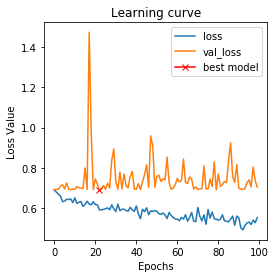

In [35]:
loss_curves_plot(model_hist)

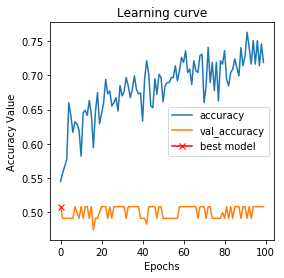

In [36]:

accuracy_curves_plot(model_hist,'binary_accuracy')